In [22]:
########################################################################
# VERSION 3
# filters applied: [ 'sobel', 'vertical', 'horizontal', 'contrast_low', 'contrast_mid', 'contrast_high',
#                   'rotate_-60_degrees',  'rotate_-40_degrees', 'rotate_-20_degrees',
#                   'rotate_+60_degrees' , 'rotate_+40_degrees', 'rotate_+20_degrees' ]
########################################################################
# original fer2013 size: 0.3 GB
# v1 size generated:     1.9 GB
# v2 size generated:     3.8 GB
# v3 size generated:     3.8 GB

In [23]:
import numpy as np
import pandas as pd
import os
from random import seed
from random import random
import seaborn as sea
import matplotlib.pyplot as plot
from tqdm.auto import tqdm
import imutils

In [24]:
dataset_filename = 'fer2013.csv'
#image sizes
im_l = 48
im_h = 48

In [25]:
#can_be_computed = [ 'local', 'colab', 'kaggle' ]
actually_computed = 'local'

In [26]:
# for local
# --------------------------------------------
if (actually_computed == 'local') :
    import_dir = ''
    export_dir = 'output_csv/'

In [27]:
# for google colab 
# --------------------------------------------
if (actually_computed == 'colab') :
    import_dir = '/content/drive/MyDrive/Colab Notebooks/DL/progetto/'
    export_dir = import_dir + 'output_csv/'

    # Mount data from drive
    from google.colab import drive
    drive.mount('/content/drive')

In [28]:
# for kaggle
# --------------------------------------------
if (actually_computed == 'kaggle') :
    import_dir = '/kaggle/input/fer2013/'
    export_dir = '/kaggle/working/output_csv/'

    if(not os.path.exists(export_dir)) :
        os.makedirs(export_dir)
    print(os.path.exists(export_dir))

In [29]:
# read fer2013 original dataset
dataset_filepath = import_dir + dataset_filename
data = pd.read_csv(dataset_filepath)

In [30]:
print(data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


Text(0, 0.5, 'Count')

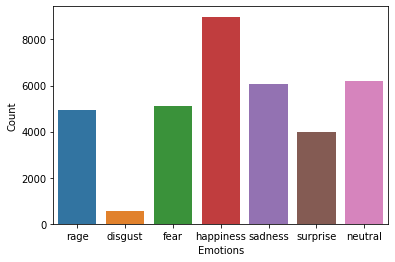

In [31]:
# dataset analysis
# list of all possible emotions
emotions = ('rage', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral')
# emotion value of each image
y = data['emotion']

# print column chart with emotion distribution
sx = sea.countplot(x=y)
plot.xticks(range(len(emotions)), emotions)
plot.xlabel("Emotions")
plot.ylabel("Count")

In [32]:
# print count of emotion distribution
num_of_emotions = data['emotion'].value_counts().sort_index()
print(num_of_emotions)

0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64


In [33]:
#conversione in np-array per guardarlo e in tensor per la rete e li scalo
#np-array of Tensor, each

def split_image_pixels(x, shape):
    temp = []
    for im in tqdm(x):
      temp.append(np.array(im.split()).reshape(shape).astype('double'))
    return temp

shape = (im_h,im_l)
original_images = split_image_pixels(data['pixels'], shape)

100%|██████████| 35887/35887 [00:55<00:00, 646.23it/s] 


In [34]:
# transform a np.array from matrix (L,H) to array (L*H,1)
def flat_image(image, im_l=im_l, im_h=im_h) :
    return image.reshape(im_l*im_h)

# transform a np.array from array (L*H,1) to matrix (L,H)
def unflat_image(image,im_l,im_h) :
    return np.array([ np.array(image[im_h*i:im_h*(i+1)]) for i in range(im_l) ])

In [35]:
# apply min max scaler to image, so all pixels will be in range(0,255)
def scale_image_to_int_in_bounds(image, im_l=im_l, im_h=im_h) :
    # flat image to one-dimensional np.array
    flatted_image = flat_image(image)
    # get image bounds
    tot_max = max(flatted_image)
    tot_min = min(flatted_image)
    scaled = np.zeros(im_l * im_h)
    # check if image has a constant color
    if (tot_min == tot_max) :
        #image of just one constant color
        constant = tot_min
        if (constant > 0 and constant <= 255) :
            #if the constant is in image bounds use the constant, else use all zeros (black image)
            scaled = flatted_image
    else :
        #image not a costant ==> (tot_max - tot_min) != 0
        scaled = np.array([int(255 * (pixel - tot_min) / (tot_max - tot_min)) for pixel in flatted_image])
    # unflat image to original dimensions L*H
    unflatted = unflat_image(scaled, im_l, im_h)
    return unflatted

In [36]:
# filters_lambda: apply a transformation to each pixel independently
# NB: (x,y): filter coordinates (NOT image), pix: color inside the pixel
#some traditional filter
filters_lambda = {
    #'original'     : (lambda x,y,pix: (pix)),
    'contrast_low'  : (lambda x,y,pix: (pix ** (1/2))),
    'contrast_mid'  : (lambda x,y,pix: (pix ** 2)),
    'contrast_high' : (lambda x,y,pix: (pix ** 3)) 
}

In [37]:
#function apply_filter_as_lambda : 
#  applies the filter as lamba instruction
# input parameters :
#  - image :         the original image 
#  - filter_lambda : lambda instruction of the filter, it's building with (x,y,pix),
#                         where pix is value of pixel, x and y are the points on the filter matrix, x,y: 0<=x<filter_size and 0<=y<filter_size
#  - filter_size :   the size of filter
# output : 
#  - new image as matrix, with dimensionality as original image 
# NO STRIDE is applied
def apply_filter_as_lambda(image, filter_lambda, filter_size=(3,3)):
  im_h = image.shape[0]
  im_l = image.shape[1]
  new_image = np.zeros(image.shape)
  for x in range(-1, im_h-filter_size[0]+1):
    for y in range(-1, im_l-filter_size[1]+1):
      for x1 in range(0, filter_size[0]):
        for y1 in range(0, filter_size[1]):
            i = x + x1
            j = y + y1
            in_image_bounds = (i >= 0) and (j >= 0) and (i <= im_h) and (j <= im_l)
            if in_image_bounds :
                new_image[x+1][y+1] += filter_lambda(x1,y1,image[i][j])
      #newImage[x+1][y+1] /= (filter_size ** 2)
  return scale_image_to_int_in_bounds(new_image)

In [38]:
#some default matrix filters
filters_matrix = {
    'horizontal_edges' : np.array([ [ 1,  2,  1], [ 0,  0,  0], [-1, -2, -1] ]),
    'vertical_edges'   : np.array([ [ 1,  0, -1], [ 2,  0, -2], [ 1,  0, -1] ])
}

for key, item in filters_matrix.items() :
    print(key, ":\n", item)

horizontal_edges :
 [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]
vertical_edges :
 [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]


In [39]:
#function apply_filter_as_matrix : 
#  applies the filter as lamba instruction
# input parameters :
#  - image :  the original image 
#  - filter : the filter matrix (as np.array)
# output : 
#  - new image as matrix, with dimensionality as original image
def apply_filter_as_matrix(image, filter_matrix, im_l=im_l, im_h=im_h) :
    
    filter_size = filter_matrix.shape                     #tipically (3,3) or (5,5)
    pad_size = (filter_size[0] // 2, filter_size[1] // 2) #tipically (1,1) or (2,2)
    
    padded_image = np.pad(image, pad_size)    
    filtered_image = [ [] for i in range(im_h) ]
    
    for im_x in range(pad_size[0], im_h + pad_size[0]):
        for im_y in range(pad_size[1], im_l + pad_size[1]):
            new_pixel = 0
            for fil_x in range(0, filter_size[0]):
                for fil_y in range(0, filter_size[1]):
                    im_i = im_x - pad_size[0] + fil_x
                    im_j = im_y - pad_size[1] + fil_y
                    new_pixel += padded_image[im_i][im_j] * filter_matrix[fil_x][fil_y]
            filtered_image[im_x - pad_size[0]].append(new_pixel)
            
    return np.array(filtered_image)

In [40]:
# before invoking sobel_filter function apply and pass vertical and horizontal filters to image :
#vertical_image   = apply_filter_as_matrix(image, horizontal_edge_filter)
#horizontal_image = apply_filter_as_matrix(image, vertical_edge_filter)

def sobel_filter(vertical_image, horizontal_image, im_l=im_l, im_h=im_h) :

    vertical_image_square   = np.multiply(vertical_image,   vertical_image)
    horizontal_image_square = np.multiply(horizontal_image, horizontal_image)
    
    return np.sqrt(vertical_image_square + horizontal_image_square)

In [41]:
all_filters = [
    'contrast_low',
    'contrast_mid',
    'contrast_high',
    'horizontal_edges',
    'vertical_edges',
    'sobel',
    'flip_horizontal',
    'rotate_-60_degrees',
    'rotate_-40_degrees',
    'rotate_-20_degrees',
    'rotate_+20_degrees',
    'rotate_+40_degrees',
    'rotate_+60_degrees'    
]

In [42]:
def generate_all_filters(image, im_l=im_l, im_h=im_h) :
    
    filtered_images = []
    #filters_names = []
    
    #lambdas : contrasts for now
    for filter_name, filter_lambda in filters_lambda.items() :
        filtered_images.append(apply_filter_as_lambda(image, filter_lambda))
        #filters_names.append(filter_name)
    
    #matrixes : horizontal and vertical for now
    hor = []
    ver = []
    for filter_name, filter_matrix in filters_matrix.items() :
        filtered = apply_filter_as_matrix(image, filter_matrix)
        filtered_images.append(filtered)
        #filters_names.append(filter_name)
        if filter_name == 'horizontal_edges' :
            hor = filtered
        elif filter_name == 'vertical_edges' :
            ver = filtered
            
    # others: sobel, flips, rotations for now
    
    #sobel
    filtered_images.append(sobel_filter(ver, hor))
    #filters_names.append('sobel')
    
    #horizontal flip
    filtered_images.append(np.flip(image, 1))
    
    #rotations
    rot_min = -60
    rot_max = 60
    rot_step = 20
    for degrees in range(rot_min, rot_max+1, rot_step) :
        if not degrees == 0 :
            rotated = imutils.rotate(image, degrees)
            #print(degrees, type(rotated))
            #print(rotated)
            filtered_images.append(rotated)
    
    return np.array(filtered_images)

In [43]:
#prints image
def print_image(ima, labelI, val=False, subpl="",title=""):
    if subpl=="":
      plot.imshow(ima, cmap='gray')
      plot.title(emotions[labelI]+ ((" "+ str(labelI)) if val else ""))
    else :
      subpl.imshow(ima, cmap='gray')
      subpl.set_title(((" "+ str(title)) if title!="" else ""))

In [47]:
#list: all images
print("all images:\t", len(original_images), "\t", type(original_images))
#np.array : first image
print("first image (L):", len(original_images[0]), "\t", type(original_images[0]))
#np.array : first line of first image
print("first image (H):", len(original_images[0][0]), "\t", type(original_images[0][0]))
#float
print("first pixel:\t", 0, "\t", type(original_images[0][0][0]))

all images:	 35887 	 <class 'list'>
first image (L): 48 	 <class 'numpy.ndarray'>
first image (H): 48 	 <class 'numpy.ndarray'>
first pixel:	 0 	 <class 'numpy.float64'>


img_idx: 2791
emotion: rage


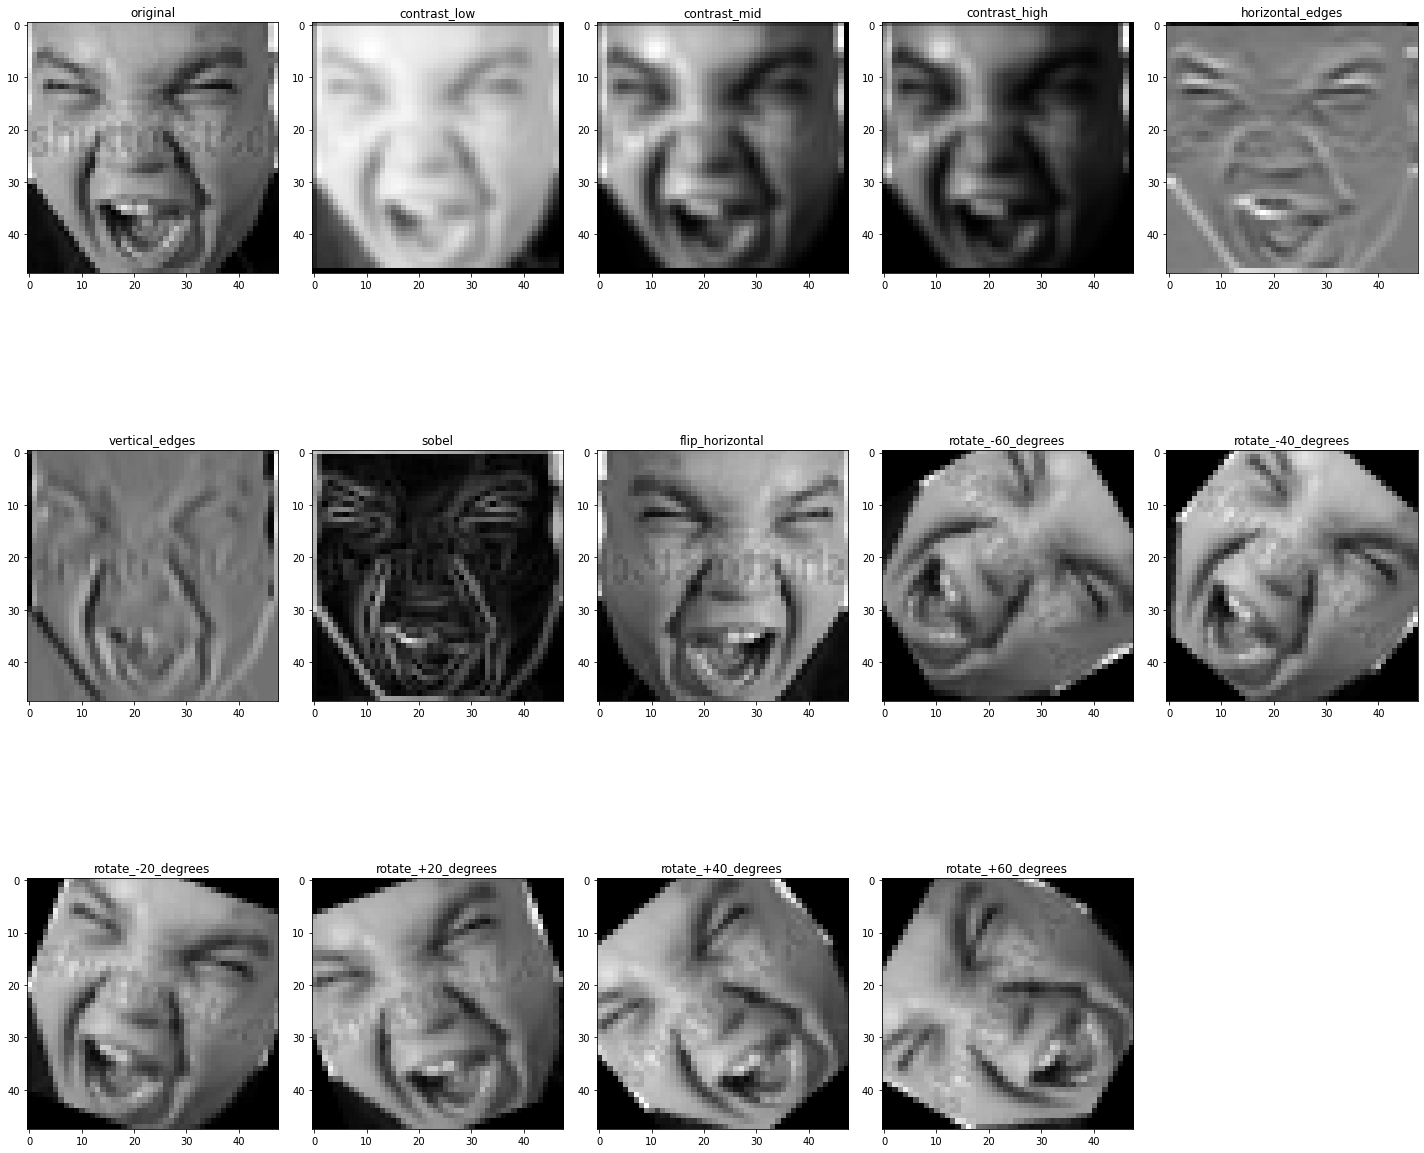

In [101]:
#print a random example
seed(None)
img_idx = int(random() * len(y))

print('img_idx:', img_idx)
print('emotion:', emotions[y[img_idx]])

rows = 3
cols = len(all_filters) // rows + 1
fig, axs = plot.subplots(rows,cols,figsize=(20,20))
filter_size = (3,3)

# already counted first original image
i = 0
j = 0
idx = 0

cur_image = original_images[img_idx]
filtered_images = generate_all_filters(cur_image)
filter_names = all_filters

# add original image
idxs = max(i,j) if (rows == 1 or cols == 1) else (i,j)
axs[idxs].imshow(cur_image, cmap='gray')
axs[idxs].set_title("original")
idx += 1

cur_filter = 0

# start with filters
for cur_filtered_image in filtered_images :
    i = (idx // cols)
    j = (idx % cols)
    idxs = max(i,j) if (rows == 1 or cols == 1) else (i,j)
    subpl=axs[idxs]
    subpl.imshow(cur_filtered_image, cmap='gray')
    subpl.set_title(filter_names[cur_filter])
    plot.tight_layout()
    plot.subplots_adjust(hspace=None)
    #print_image(cur_filtered_image, 0, subpl=axs[idxs], title=filter_names[cur_filter])
    cur_filter += 1
    idx += 1

# remove empty images
tot_images = len(filtered_images) + 1
empty_axs = tot_images - (rows * cols)
for r in range(rows) :
    for c in range(cols):
        #print(r,c, c+r*cols, tot_images)
        if (c + r * cols) >= tot_images :
            print(end="")
            fig.delaxes(axs[r][c])
            
#plot.tight_layout(pad=-1)

In [113]:
# convert an array to a string delimited by char (default space)
def array_to_string(array, char=' ') :
    return char.join(str(number) for number in array.astype(int))

In [105]:
# create list with all filters of all images
def build_new_dataset(original_images) :
    new_dataset = []
    for original_image in tqdm(original_images):
      # image list
      all_image_filters = []
      # add original image to image list
      all_image_filters.append(array_to_string(flat_image(original_image, im_l, im_h)))
      # generate all filters of image
      filtered_images = generate_all_filters(original_image)
      # add one by one all the filters to image list
      for cur_filtered_image in filtered_images :
        all_image_filters.append(array_to_string(flat_image(cur_filtered_image)))
      # add all the image list to dataset
      new_dataset.append(all_image_filters)
    return new_dataset

In [106]:
#data_len = len(original_images)
data_len = 50
#print(data_len)
new_dataset = build_new_dataset(original_images[:data_len])

100%|██████████| 50/50 [00:08<00:00,  6.07it/s]


In [114]:
# counts occurences of a char in a string 
# used to count separator ' ' and check if output is correct
def count_char(string, char=' ') :
    c = 0
    for i in range(len(string)) :
        if string[i] == char :
            c += 1
    return c

In [115]:
# check visually types and dimension obtained of first element
l1 = len(new_dataset)
t1 = type(new_dataset)
l2 = len(new_dataset[0])
t2 = type(new_dataset[0])
l3 = count_char(new_dataset[0][0])
t3 = type(new_dataset[0][0])
print(l1, "\t", t1)
print(l2, "\t", t2)
print(l3, "\t", t3)

50 	 <class 'list'>
14 	 <class 'list'>
2303 	 <class 'str'>


In [116]:
# check lengths and types of all images
ok = True
for image in new_dataset :
    new_l2 = len(image)
    new_t2 = type(image)
    if new_l2 != l2 or new_t2 != t2:
        print("2:", new_l2, "\t", new_t2)
        ok = False
    for im_filter in image :
        new_l3 = count_char(im_filter)
        new_t3 = type(im_filter)
        if new_l3 != l3 or new_t3 != t3:
            print("3:", new_l3, "\t", new_t3)
            ok = False
print(ok)        

True


In [117]:
def get_columns(filters=all_filters) :
    all_columns = ['original']
    for cur_fil in filters :
        all_columns.append(cur_fil)
    return all_columns

In [118]:
new_columns = get_columns()
new_dataset_df = pd.DataFrame(new_dataset, columns = new_columns)

In [111]:
emotions_usage_df = data[['emotion','Usage']][:data_len]
final_dataset_df = pd.concat([emotions_usage_df, new_dataset_df], axis=1)

In [119]:
# print random row in dataset:
seed(None)
img_idx = int(random() * data_len)
print('img_idx:', img_idx)
print(final_dataset_df[img_idx:img_idx+1].T)


img_idx: 29
                                                                   29
emotion                                                             5
Usage                                                        Training
original            50 44 74 141 187 187 169 113 80 128 181 172 76...
contrast_low        58 96 113 132 141 140 127 115 115 127 137 125 ...
contrast_mid        8 21 40 70 88 89 66 43 40 61 79 64 35 11 8 6 6...
contrast_high       2 8 22 49 69 72 49 26 21 41 58 47 22 3 1 1 1 1...
horizontal_edges    -172 -314 -420 -474 -475 -412 -324 -280 -326 -...
vertical_edges      -164 -114 -234 -240 -79 86 186 184 -82 -254 -6...
sobel               237 334 480 531 481 420 373 335 336 499 460 45...
flip_horizontal     38 37 40 46 51 50 46 57 68 128 154 125 69 52 4...
rotate_-60_degrees  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 11 35 117 159 ...
rotate_-40_degrees  0 0 0 0 0 0 0 0 0 0 0 0 56 131 125 66 40 39 39...
rotate_-20_degrees  0 0 0 0 0 0 0 140 185 156 154 171 144 108 64 4...
rotate_+

surprise


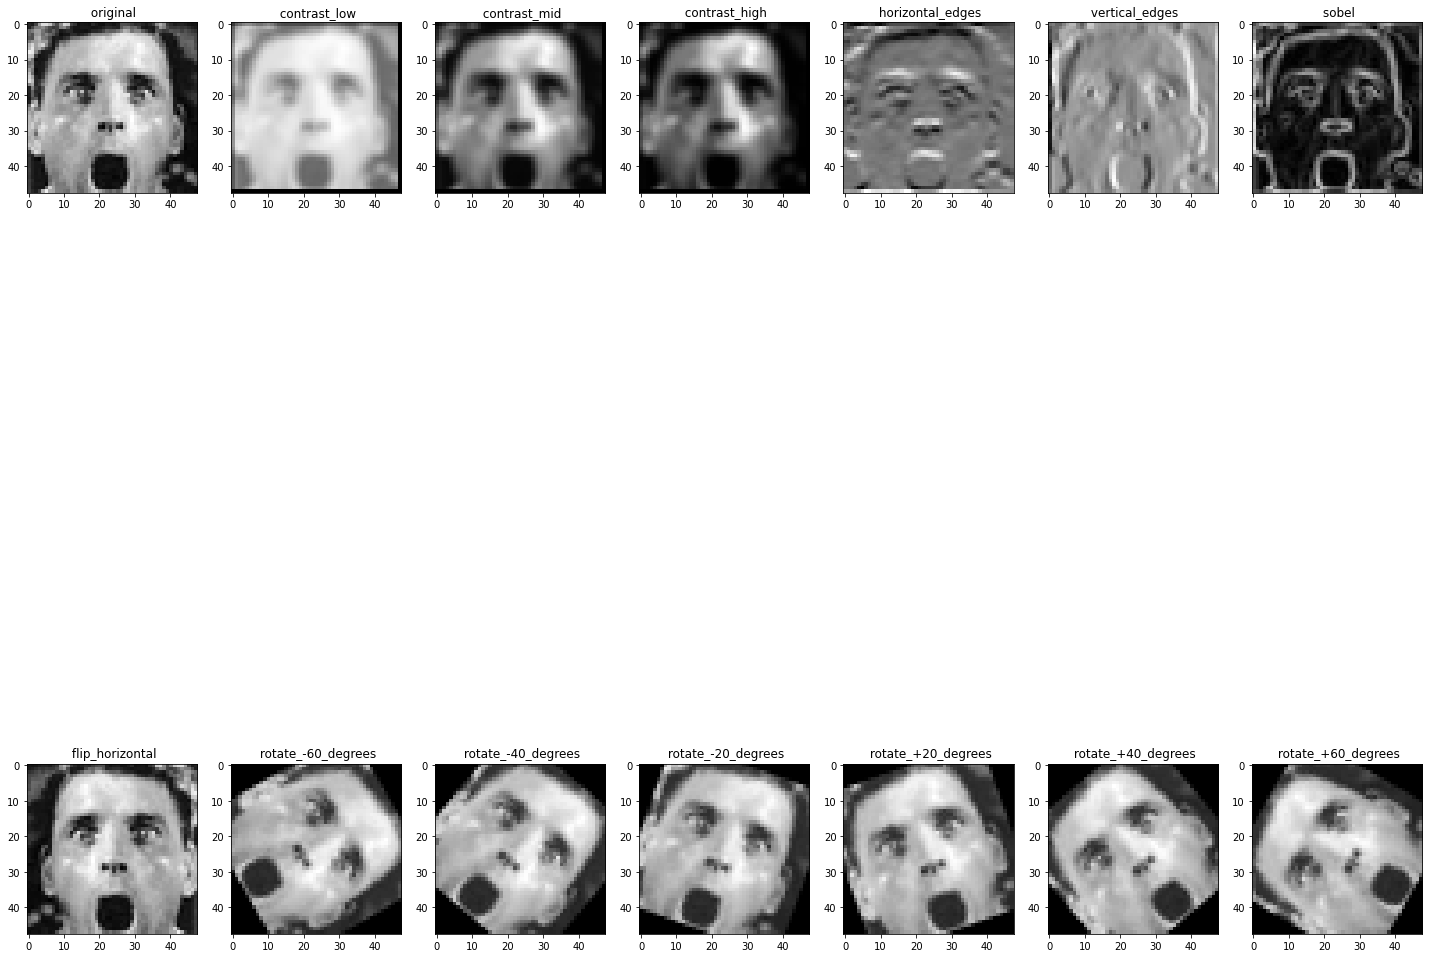

In [120]:
#test if everything ok
rows = 2
cols = len(new_dataset[0]) // 2
fig, axs = plot.subplots(rows, cols, figsize=(25,25))
filter_size = (3,3)

i=j=0
cur_im = 0
columns = get_columns()
print(emotions[y[img_idx]])
for image_str in new_dataset[img_idx] :
    image = np.fromstring(image_str, dtype=int, sep=' ').reshape(48,48)
    #print(image)
    idxs = max(i,j) if (rows == 1 or cols == 1) else (i,j)
    cur_filter = columns[cur_im]
    print_image(image, 0, subpl=axs[idxs], title=cur_filter)
    cur_im += 1
    j += 1
    if j == cols :
        j = 0; i += 1

In [59]:
csv_filename = 'fer2013_augmented.csv'

In [60]:
if (actually_computed != 'local') :
    from IPython.display import HTML
    import base64

    def create_download_link(df, title = "Download CSV file", filename = csv_filename):  
        csv = df.to_csv(index=False)
        b64 = base64.b64encode(csv.encode())
        payload = b64.decode()
        html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
        html = html.format(payload=payload,title=title,filename=filename)
        return HTML(html)

In [61]:
#write a new dataframe
if (actually_computed == 'local') :
    final_dataset_df.to_csv(csv_filename, index=False)
else :
    create_download_link(final_dataset_df)